In [384]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

import string
import argparse
import math
import numpy as np

from tqdm import tqdm
from accelerate import Accelerator
import os
from loguru import logger
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


import torch.nn.functional as F
import torch.nn.modules.transformer as transformer
from tqdm import tqdm
import json

In [385]:
len('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')

31

In [386]:
os.environ['NCCL_DEBUG'] = 'INFO'
os.environ['NCCL_SOCKET_IFNAME'] = 'lo'
os.environ['NCCL_IB_DISABLE'] = '1'
os.environ['NCCL_P2P_LEVEL'] = 'NVL'

# Define constants
MAX_LENGTH = 200
OOD_MAX_LENGTH = 400
VALID_CHARACTERS = ["s", "a", "c", "b", 'd', 'f', 'g', 'x', 'y', 'z', "e", "p"]
MAIN_CHARACTERS = ["a", "c", "b", 'd', 'f', 'g', 'x', 'y', 'z']
START_TOKEN = "s"
END_TOKEN = "e"
PADDING_TOKEN = "p"
VALID_RATIO = 0.5  # Half of the dataset should be valid a*b* strings

data_dir = '/orion/u/yrichard/n/key_trials/test_abc_200_400_padded'      # Path to the dir that contains train/test/OOD_dataset.txt, 

# Define constants for model
VOCAB_SIZE = len(VALID_CHARACTERS)
EMBEDDING_DIM = 6
NUM_HEADS = 1
NUM_LAYERS = 1
HIDDEN_DIM = 2
BATCH_SIZE = 256

# Structural change
position_embedding = 'trig'
FFN = False

EPOCHS = 10

# Mapping characters to indices
char_to_index = {ch: idx for idx, ch in enumerate(VALID_CHARACTERS)}



In [387]:
# Custom dataset class
class StringDataset(Dataset):
    def __init__(self, file_path):
        self.data = []
        self.labels = []
        with open(file_path, "r") as f:
            for line in f:
                parts = line.strip().split(" ")
                self.data.append(parts[0])
                self.labels.append(int(parts[1]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string = self.data[idx]
        label = self.labels[idx]
        encoded = self.encode_string(string)
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

    def encode_string(self, string):
        return [char_to_index[char] for char in string]

# Prepare dataset and dataloader
train_dataset = StringDataset(os.path.join(data_dir, "train_dataset.txt"))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StringDataset(os.path.join(data_dir,"test_dataset.txt"))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

ood_dataset = StringDataset(os.path.join(data_dir,"ood_dataset.txt"))
ood_dataloader = DataLoader(ood_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [388]:
# Define a custom TransformerEncoderLayer
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2, dropout=0.1):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.layernorm1(
            src + self.self_attn(src, src, src, attn_mask=src_mask, average_attn_weights = False)[0]
        )
        src = self.layernorm2(
            src + self.linear2(self.dropout(F.relu(self.linear1(src))))
        )
        return src

class NoFFNTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2, dropout=0.1):
        super(NoFFNTransformerEncoderLayer, self).__init__()
        print(f'nhead: {nhead}')
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # self.linear1 = nn.Linear(d_model, dim_feedforward)
        # self.linear2 = nn.Linear(dim_feedforward, d_model)
        # self.dropout = nn.Dropout(dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        # self.layernorm2 = nn.LayerNorm(d_model)

    def forward(self, src, src_mask=None):
        src = self.layernorm1(
            src + self.self_attn(src, src, src, attn_mask=src_mask, average_attn_weights=False)[0]
        )
        # src = self.layernorm2(
        #     src + self.linear2(self.dropout(F.relu(self.linear1(src))))
        # )
        return src

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # x here is Batchsize x sequence length
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define the model
class TransformerClassifier(nn.Module):
    def __init__(self, embedding_size=4, nhead=1, hidden_dim=2, vocab_size=1500, position_embedding='learnable', FFN=True):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=11)

        if position_embedding == 'learnable':
            self.position_embedding = nn.Embedding(vocab_size, embedding_size)
        elif position_embedding == 'trig':
            self.position_embedding = PositionalEncoding(d_model=embedding_size, max_len=vocab_size)

        if FFN == True:
            self.encoder = CustomTransformerEncoderLayer(d_model=embedding_size, nhead=nhead, dim_feedforward=hidden_dim)
        else:
            self.encoder = NoFFNTransformerEncoderLayer(d_model=embedding_size, nhead=nhead, dim_feedforward=hidden_dim)


        self.fc = nn.Linear(embedding_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        if position_embedding == 'learnable':
            x = self.embedding(x) + self.position_embedding(x) # 100(Batchsize) x 200(ood_length) x 4(emb_size)
        elif position_embedding == 'trig':
            x = self.embedding(x)   # 100(Batchsize) x 200(ood_length) x 4(emb_size)
            x = x + self.position_embedding(x.permute(1, 0, 2)).permute(1, 0, 2)



        x = x.transpose(0, 1)   # L x N x Emb

        # attn_mask = (x == 4).transpose(0, 1).unsqueeze(1).repeat(1, x.size(1), x.size(2))
        x = self.encoder(x)     # L x N x Emb

        x = x.transpose(0, 1)   # L x N x Emb
        x = x.mean(dim=1)   # N x L x Emb
        
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = TransformerClassifier(vocab_size = OOD_MAX_LENGTH, embedding_size = EMBEDDING_DIM, nhead = NUM_HEADS, hidden_dim = HIDDEN_DIM, position_embedding=position_embedding, FFN=FFN)
print(f'''Model hyperparameters: VOCAB_SIZE: {VOCAB_SIZE}, EMBEDDING_DIM: {EMBEDDING_DIM}, 
NUM_HEADS:{NUM_HEADS}, HIDDEN_DIM: {HIDDEN_DIM}, NUM_LAYERS: {1}, POSITIONAL_EMBEDDING: {position_embedding}, FFN: {FFN}''')


nhead: 1
Model hyperparameters: VOCAB_SIZE: 12, EMBEDDING_DIM: 6, 
NUM_HEADS:1, HIDDEN_DIM: 2, NUM_LAYERS: 1, POSITIONAL_EMBEDDING: trig, FFN: False


In [389]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [390]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cpu" and torch.backends.mps.is_available():
    device = torch.device("mps")
model.to(device)

TransformerClassifier(
  (embedding): Embedding(400, 6, padding_idx=11)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): NoFFNTransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
    )
    (layernorm1): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  )
  (fc): Linear(in_features=6, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [391]:
accelerator = Accelerator()
model, optimizer, train_dataloader, test_dataloader, ood_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, test_dataloader, ood_dataloader
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [392]:
if accelerator.is_main_process:
        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(train_dataloader):
                outputs = model(inputs)
                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted.squeeze() == labels).sum().item()
        print(f"Initial Accuracy on train split: {correct/total}")


100%|██████████| 625/625 [00:10<00:00, 62.16it/s]

Initial Accuracy on train split: 0.5


In [393]:
# Training loop
for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        loss = criterion(outputs.squeeze(), labels)
        accelerator.backward(loss)
        optimizer.step()
    # scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item()}, Training Accuracy: {correct/total}, Loss: {scheduler.get_last_lr()[0]}")


100%|██████████| 625/625 [00:15<00:00, 40.64it/s]


Epoch 1/10, Loss: 0.6060513257980347, Training Accuracy: 0.62835625, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.57it/s]


Epoch 2/10, Loss: 0.5973614454269409, Training Accuracy: 0.64846875, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.04it/s]


Epoch 3/10, Loss: 0.6030970811843872, Training Accuracy: 0.6508875, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.99it/s]


Epoch 4/10, Loss: 0.6260824799537659, Training Accuracy: 0.652475, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.69it/s]


Epoch 5/10, Loss: 0.6126689910888672, Training Accuracy: 0.65299375, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.35it/s]


Epoch 6/10, Loss: 0.593195915222168, Training Accuracy: 0.65464375, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 40.59it/s]


Epoch 7/10, Loss: 0.6595374345779419, Training Accuracy: 0.65429375, Loss: 0.005


100%|██████████| 625/625 [00:15<00:00, 39.52it/s]


Epoch 8/10, Loss: 0.6620364189147949, Training Accuracy: 0.65554375, Loss: 0.005


 25%|██▌       | 159/625 [00:03<00:11, 41.23it/s]

In [ ]:
# Save the trained model
if accelerator.is_main_process:
    model_path = os.path.join(data_dir, f'model_{EMBEDDING_DIM}_{NUM_HEADS}_{NUM_LAYERS}_{EPOCHS}_{position_embedding}_{FFN}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Model saved to /orion/u/yrichard/n/key_trials/test_even-a_200_400_padded/model_12_2_2_25_trig_True.pth


In [ ]:
# Print accuracy of the model
if accelerator.is_main_process:
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            outputs = model(inputs.to(device))
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    print(f"Test Accuracy: {correct/total}")


100%|██████████| 16/16 [00:00<00:00, 56.07it/s]

Test Accuracy: 0.5


In [ ]:
# Print accuracy of the model on OOD dataset
if accelerator.is_main_process:
    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(ood_dataloader):
            outputs = model(inputs)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    print(f"OOD Accuracy: {correct/total}")


100%|██████████| 118/118 [00:02<00:00, 53.18it/s]

OOD Accuracy: 0.5


# Interpretability

In [ ]:
data_iterator = iter(train_dataloader)
single_batch = next(data_iterator)
sample = single_batch[0][0].unsqueeze(0)
sample.shape

torch.Size([1, 400])

In [ ]:
sample.shape

torch.Size([1, 400])

tensor([[0.5053]], grad_fn=<SigmoidBackward0>)
attn_weights:  torch.Size([1, 2, 400, 400])
src:  torch.Size([400, 1, 12])
Original string:  ppppppppppppppppppppppppppppppsabbabcabbcbacbababcacbacbacbabepppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp
Original list:  ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 's', 'a', 'b', 'b', 'a', 'b', 'c', 'a', 'b', 'b', 'c', 'b', 'a', 'c', 'b', 'a', 'b', 'a', 'b', 'c', 'a', 'c', 'b', 'a', 'c', 'b', 'a', 'c', 'b', 'a', 'b', 'e', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p', 'p

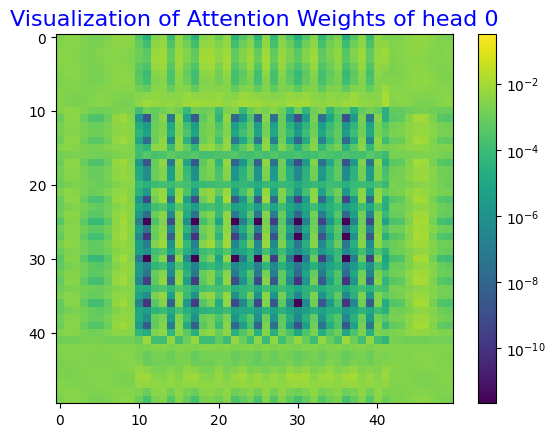

Top 30 positions of highest attention weights for head 1:  tensor([323,  61, 179, 298, 329, 178, 185, 324, 330,  65, 184, 304,  66, 210,
        322, 297, 317, 292, 153, 299, 204, 354, 355, 328,  28, 172, 154,  35,
         33,  60])
sub_shown: (400, 400)


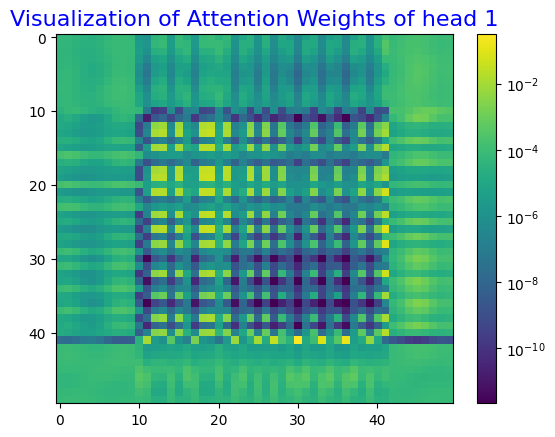

Top 30 positions of highest attention weights for head 2:  tensor([ 61, 153,   8, 152,   9, 154,   7, 121,  39, 184,  57, 297, 122,  65,
        298,   2,  38, 272,  33, 127, 178, 151,  64,   3, 183, 266,  96, 185,
        128, 271])
FFN: True
src:  torch.Size([400, 1, 12])
attn_weights_projected:  torch.Size([400, 2])
before_logits:  torch.Size([400, 12])
Top 30 positions of highest attention output:  tensor([271, 152, 296, 384, 265, 240, 359,  40, 385, 297, 328, 239, 272, 353,
        390])
Top 30 positions of highest attn_weights_projected:  tensor([144,   0,  24,  18, 150,   6,  25,  31, 137, 143, 138,  37,  42,  12,
         34, 288,  56,  50, 282,  47, 151,  19, 145, 263, 131,  53,  17, 257,
         45, 112])
Top 30 positions of highest before_logits:  tensor([152, 240, 359,  40, 385, 297, 328, 272, 353, 391, 327, 303, 360, 266,
         57, 183,  61, 208, 121, 209,  51, 127, 241, 215, 354, 234,  95, 246,
        214, 352])
shown2: [[ 4.57446188e-01  2.35546899e+00]
 [-1.0517686

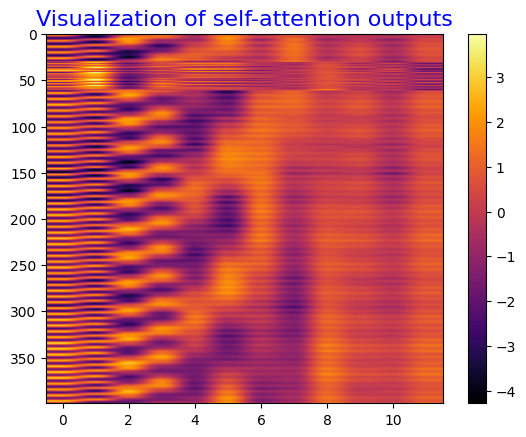

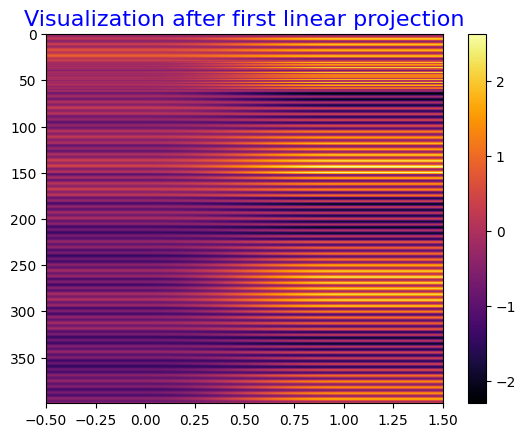

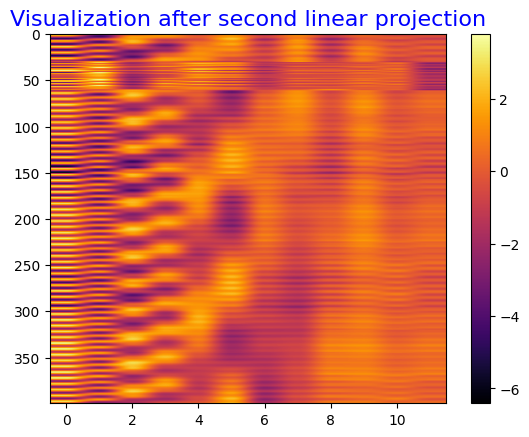

In [ ]:
# Load model, pick random sample from training set and print attention weights
model = model.to('cpu')

model.eval()

#RANDOM SAMPLE APPROACH
# data_iterator = iter(train_dataloader)
# single_batch = next(data_iterator)
# sample = single_batch[0][1]  # Adjust indexing if your dataloader returns multiple values like (features, labels)
# x = sample.unsqueeze(0).to('cpu')

#CUSTOME APPROACH
core = 'abbabcabbcbacbababcacbacbacbab'
string = 'p' * 30 + 's' + core + 'e' + 'p' * (OOD_MAX_LENGTH - 30 - len(core) - 2)
sample = torch.tensor([char_to_index[char] for char in string])
x = sample.to('cpu').unsqueeze(0)
#############################################


output = model(x)
print(output)

if position_embedding == 'learnable':
    x = model.embedding(x) + model.position_embedding(x) # 100(Batchsize) x 200(ood_length) x 4(emb_size)
elif position_embedding == 'trig':
    x = model.embedding(x)   # 100(Batchsize) x 200(ood_length) x 4(emb_size)
    x = x + model.position_embedding(x.permute(1, 0, 2)).permute(1, 0, 2)



x = x.transpose(0, 1)       # OOD x Batch x EMB
attn_raw_output, attn_weights = model.encoder.self_attn(x, x, x, attn_mask=None, average_attn_weights=False)      # Batch x OOD_length x OOD_length
src = model.encoder.layernorm1(attn_raw_output + x)        # OOD x BATCH x EMB

print('attn_weights: ', attn_weights.shape)
print('src: ', src.shape)

# Print the original string
original_string = "".join(VALID_CHARACTERS[i] for i in sample.tolist())
original_list = list(original_string)
original_dict = {i:original_list[i] for i in range(len(original_list))}
# Plot matrix of attention weights
print('Original string: ',"".join(VALID_CHARACTERS[i] for i in sample.tolist()))
print('Original list: ', original_list)

with open('original_dict.json', 'w') as file:
    json.dump(original_dict, file, indent=4)

    

shown = attn_weights.squeeze(0).detach().numpy()
print('shown.shape: ', shown.shape)

# Visualize the attention weights from potentially multiple attention heads
if len(shown.shape) == 2:
    norm = mcolors.LogNorm(vmin=shown[shown > 0].min(), vmax=shown.max())
    plt.imshow(shown[20:70, 20:70], cmap='viridis', norm=norm, aspect='auto')
    plt.title("Visualization of Attention Weights", fontsize=16, color='blue')
    plt.colorbar()
    plt.show()
    print('Top 30 positions of highest attention weights: ', torch.topk(attn_weights.squeeze(0).mean(dim=0), 30).indices)

else:
    for i in range(shown.shape[0]):
        sub_shown = shown[i]
        print(f'sub_shown: {sub_shown.shape}')
        norm = mcolors.LogNorm(vmin=shown[shown > 0].min(), vmax=shown.max())
        plt.imshow(sub_shown[20:70, 20:70], cmap='viridis', norm=norm, aspect='auto')
        plt.title(f"Visualization of Attention Weights of head {i}", fontsize=16, color='blue')
        plt.colorbar()
        plt.show()
        print(f'Top 30 positions of highest attention weights for head {i+1}: ', torch.topk(torch.tensor(sub_shown).mean(dim=0), 30).indices)

print(f'FFN: {FFN}')

# Handle the case of FFN removed
if FFN == False:
    print('Top 15 positions of highest attention output: ', torch.topk(src[20:70].squeeze(1).mean(dim=1), 15).indices)
    shown4 = src.squeeze(1).detach().numpy()

    print(f'shown4: {shown4}')
    min_val, max_val = shown.min(), shown.max()
    print(min_val, max_val)
    range_val = max_val - min_val

    # plt.imshow(shown, cmap='inferno', vmin=min_val, vmax=max_val)
    # plt.colorbar()
    # plt.show()

    plt.imshow(shown4[20:70], cmap='inferno', aspect='auto')
    plt.title("Attention Outputs of Learnable Positional Encoding", fontsize=16, color='blue')
    plt.colorbar()
    plt.show()

    print('Top 15 positions of highest attention output: ', torch.topk(torch.tensor(shown4).mean(dim=1), 15).indices)
    print('Top 15 positions of lowest attention output: ', torch.topk(torch.tensor(shown4).mean(dim=1), 15, largest=False).indices)


else:
    print('src: ', src.shape)
    attn_weights_projected = model.encoder.linear1(src).squeeze(1)      # Projected to lower dim
    before_logits = src.squeeze(1) + model.encoder.linear2(model.encoder.dropout(F.relu(attn_weights_projected)))  # Projects back

    print('attn_weights_projected: ', attn_weights_projected.shape)
    print('before_logits: ', before_logits.shape)
    # print(attn_weights.squeeze(0).mean(dim=0))
    # Print indices of top 10 attention weights
    print('Top 30 positions of highest attention output: ', torch.topk(src.squeeze(1).mean(dim=1), 15).indices)
    print('Top 30 positions of highest attn_weights_projected: ', torch.topk(attn_weights_projected.squeeze(0).mean(dim=1), 30).indices)
    print('Top 30 positions of highest before_logits: ', torch.topk(before_logits.squeeze(0).mean(dim=1), 30).indices)



    # Plot matrix of attention weights
    import matplotlib.pyplot as plt

    shown2 = attn_weights_projected.detach().numpy()
    shown3 = before_logits.detach().numpy()
    shown4 = src.squeeze(1).detach().numpy()
    print(f'shown2: {shown2}')
    print(shown3.shape)
    print(shown4.shape)

    # plt.imshow(shown)
    # plt.colorbar()
    # plt.show()

    min_val, max_val = shown.min(), shown.max()
    print(min_val, max_val)
    range_val = max_val - min_val

    # plt.imshow(shown, cmap='inferno', vmin=min_val, vmax=max_val)
    # plt.colorbar()
    # plt.show()

    plt.imshow(shown4, cmap='inferno', aspect='auto')
    plt.title("Visualization of self-attention outputs", fontsize=16, color='blue')
    plt.colorbar()
    plt.show()


    plt.imshow(shown2, cmap='inferno', aspect='auto')
    plt.title("Visualization after first linear projection", fontsize=16, color='blue')
    plt.colorbar()
    plt.show()

    # Load your data array here (assuming shown3 is already loaded)
    min_val = shown3.min()  # Replace with your actual min value
    max_val = shown3.max()  # Replace with your actual max value

    plt.imshow(shown3, cmap='inferno', aspect='auto')
    plt.title("Visualization after second linear projection", fontsize=16, color='blue')
    plt.colorbar()
    plt.show()



In [ ]:
attn_weights.shape

torch.Size([1, 2, 400, 400])

In [ ]:
print(shown4)

[[-1.2831708   1.0814005  -1.3239077  ...  0.14881438 -1.0302138
   0.3995502 ]
 [ 1.5559835  -0.6479992  -0.7345929  ... -0.03156203 -1.1765611
   0.2879395 ]
 [ 1.5745604  -3.2456505   0.4780412  ... -0.18601315 -0.7071468
   0.19345148]
 ...
 [ 2.4511154   0.5951064  -1.7557389  ...  0.16155954  0.04807461
   0.7989022 ]
 [ 2.411301   -1.3333975  -1.8452926  ...  0.25167096  0.1629947
   0.8888835 ]
 [ 0.5703085  -2.1668503  -1.9075549  ...  0.40046546  0.30122337
   1.0488813 ]]


In [ ]:
with open("output.json", "w") as f:
    json.dump(list(shown4), f)

TypeError: Object of type ndarray is not JSON serializable